We are looking at the problem MAX K XOR, where each variable is involved in $D+1$ clauses and has no overlapping constraints.

This is code comparing one-local algorithms: Hirvonen's threshold algorithm and Farhi's QAOA at depth 1.

In [1]:
from functools import lru_cache
from numpy import cos, sin, tan, arctan as atan
from scipy.optimize import minimize
from scipy.special import binom, erf
from sympy import exp, simplify, expand, expand_trig, trigsimp
import matplotlib.pyplot as plt
import numpy as np
import sympy
import time

In [2]:
print("Starting time:", time.ctime())

Starting time: Mon Jun 14 23:34:33 2021


# QAOA for MAX 3 XOR

In [3]:
def qaoa_perf_3xor(s, D):
    return s/ ( 1 + 3/(1 - s*s)**D)**0.5

In [4]:
gamma = sympy.Symbol('gamma')
D_symbol = sympy.Symbol('D')
qaoa_perf_3xor(sympy.sin(gamma), D_symbol)

(1 + 3*(1 - sin(gamma)**2)**(-D))**(-0.5)*sin(gamma)

In [5]:
Ds = [5, 10, 20, 50, 100, 500, 1000, 5000, 10000, 50000, 500000]
inps = np.linspace(0, 3, 100000)

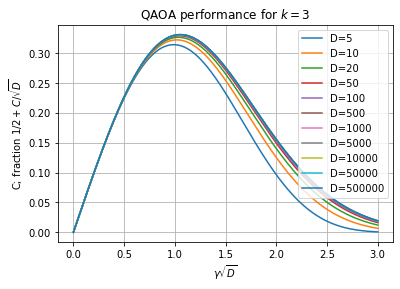

In [6]:
for D in Ds:
    outs = [qaoa_perf_3xor(np.sin(i*D**-0.5), D)*D**0.5 for i in inps]
    plt.plot(inps, outs, label="D=" + str(D))
plt.grid()
plt.legend()
plt.title("QAOA performance for $k=3$")
plt.xlabel("$\gamma \sqrt{D}$")
plt.ylabel("C; fraction $1/2 + C/\sqrt{D}$")
plt.savefig("QAOA_max3xor.png",  dpi=300)

We can also look at the derivative of performance with respect to $\gamma$:

In [7]:
qaoa_perf_derivative = sympy.lambdify((gamma, D_symbol), sympy.Derivative(qaoa_perf_3xor(sympy.sin(gamma), D_symbol), gamma, evaluate=True))

5 0.9889298892988929 -7.89382122379223e-06
10 1.019440194401944 -5.557421224877679e-07
20 1.035970359703597 9.036765468040109e-06
50 1.0463804638046381 -6.05624229221835e-06
100 1.049920499204992 -3.116431702476774e-06
500 1.052770527705277 7.448490694839105e-06
1000 1.053130531305313 7.55082733017165e-06
5000 1.053430534305343 -1.179938904916078e-07
10000 1.053460534605346 3.909266844126513e-06
50000 1.053490534905349 3.155058544646039e-06
500000 1.053490534905349 7.4604497740105025e-06


Text(0.5, 1.0, 'first derivative')

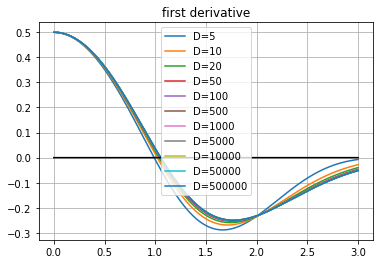

In [8]:
for D in Ds:
    outs = [qaoa_perf_derivative(i*D**-0.5, D) for i in inps]
    plt.plot(inps, outs, label="D=" + str(D))
    pt = np.argmin(np.abs(outs))
    print(D, inps[pt], outs[pt])
plt.grid()
plt.plot(inps, [0]*inps, color='black')
plt.legend()
plt.title("first derivative")

Let's check to make sure this works given $\gamma$ and $\beta$. Using the asymptotic values:

In [9]:
def qaoa_perf_2var_3xor(beta, gamma, D):
    p, q = np.cos(2*beta), np.sin(2*beta)
    c, s = np.cos(gamma), np.sin(gamma)
    return 0.5*q*s*(3*p*p*c**D - q*q*c**(3*D))

In [10]:
D =100
gamma = 1.0535/D**0.5
beta = np.arcsin((1/(np.cos(gamma)**(2*D) + 3))**0.5)/2
print(beta, gamma)
print(qaoa_perf_2var_3xor(beta, gamma, D)*D**0.5)

0.29003649304891665 0.10535000000000001
0.3305431427004284


Text(0.5, 1.0, 'QAOA for MAX 3 XOR')

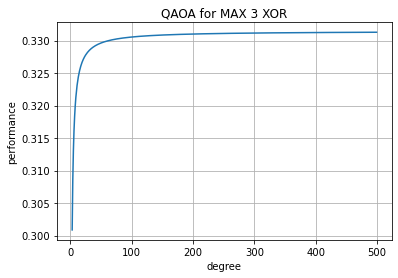

In [11]:
Ds = range(3, 500, 1)
plt.plot(Ds, [qaoa_perf_2var_3xor(0.29, 1.0535/D**0.5, D)*D**0.5 for D in Ds])
plt.grid()
plt.xlabel("degree")
plt.ylabel("performance")
plt.title("QAOA for MAX 3 XOR")

Text(0.5, 1.0, 'QAOA for MAX 3 XOR')

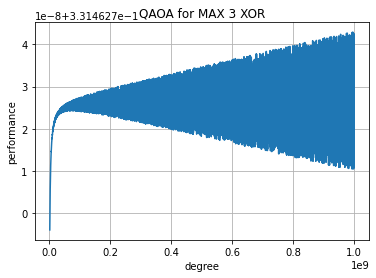

In [12]:
Ds = range(3000000, 1000000000, 100000)
plt.plot(Ds, [qaoa_perf_2var_3xor(0.29, 1.0535/D**0.5, D)*D**0.5 for D in Ds])
plt.grid()

plt.xlabel("degree")
plt.ylabel("performance")
plt.title("QAOA for MAX 3 XOR")

What's the asymptotic value of QAOA on MAX 3 XOR?

In [13]:
def v(k):
    return k / (1 + 3*exp(k*k))**0.5

In [14]:
k = sympy.Symbol('k')
der = sympy.lambdify(k, sympy.Derivative(v(k), k, evaluate=True))

In [15]:
sympy.Derivative(v(k), k, evaluate=True)

-3.0*k**2*(3*exp(k**2) + 1)**(-1.5)*exp(k**2) + (3*exp(k**2) + 1)**(-0.5)

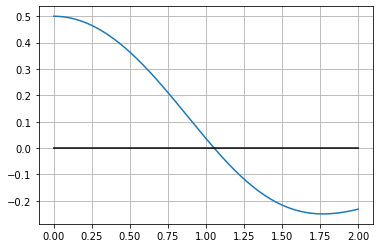

In [16]:
inps = np.linspace(0, 2, 10000000)
plt.plot(inps, der(inps))
plt.plot(inps, [0]*inps, color='black')
plt.grid()

In [17]:
pt = np.argmin(np.abs(der(inps)))
inps[pt], der(inps)[pt]

(1.0535025053502505, 3.2796303450766118e-09)

In [18]:
v(inps[pt])

0.331462726717571

What are the optimal values of QAOA for every degree?

In [19]:
fmaker = lambda D: lambda i: -qaoa_perf_3xor(np.sin(i*D**-0.5), D)*D**0.5

In [20]:
Ds = range(2, 10000)

In [21]:
optimized_vals = [-minimize(fmaker(D), 1).fun for D in Ds]

In [22]:
comparison = [qaoa_perf_2var_3xor(0.29, 1.0535/D**0.5, D)*D**0.5 for D in Ds]
assert np.all(np.array([o-c for o,c in zip(optimized_vals, comparison)]) > 0)

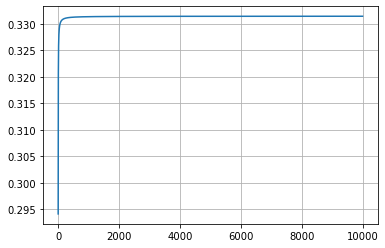

In [23]:
plt.plot(Ds, optimized_vals)
plt.grid()

# The threshold algorithm for MAX 3 XOR

In [24]:
@lru_cache(maxsize=int(1e7))
def g(D, t):
    return 2**(-D) * sum([binom(D,i) for i in range(0, t+1)])

In [25]:
@lru_cache(maxsize=int(1e7))
def Delta(D, t):
    return 2**(-D)* binom(D, t)

In [26]:
@lru_cache(maxsize=int(1e7))
def general_improvement(D, t, k):
    val_delta = Delta(D, t)
    val_g = g(D, t)
    return 0.25 * ( (1-2*val_g + 2*val_delta)**k - (1 - 2*val_g)**k )

What's the performance at $k=3$?

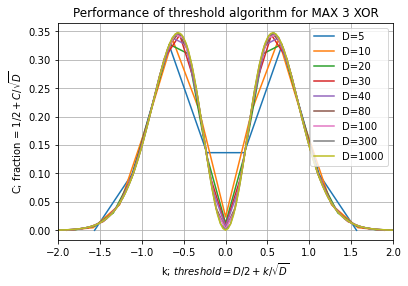

In [27]:
for D in [5, 10, 20, 30, 40, 80, 100, 300, 1000]:
    inps = np.array(list(range(-1, D+2)))
    plt.plot((inps/D - 1/2)*D**0.5, [general_improvement(D, t, 3)*D**0.5 for t in inps], label="D=" + str(D))

plt.legend()
plt.ylabel("C; fraction = $1/2 + C/\sqrt{D}$")
plt.xlabel("k; $threshold = D/2 + k/\sqrt{D}$")
plt.xlim(-2, 2)
plt.title("Performance of threshold algorithm for MAX 3 XOR")
plt.grid()

Finding the optimal threshold:

In [28]:
def get_argmax(D, k, negative_only=False):
    if negative_only:
        inps = range(-1, int(D/2))
    else:
        inps = range(-1, D+2)
    return inps[np.argmax([general_improvement(D, t, k) for t in inps])]

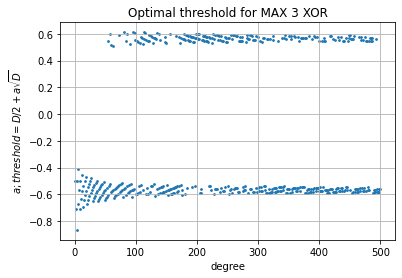

In [29]:
inps = range(1, 500)
plt.scatter(inps, [(get_argmax(D, 3) - D/2)/D**0.5 for D in inps], s=3)
plt.xlabel("degree")
plt.ylabel("$ a; threshold= D/2 + a \sqrt{D}$")
plt.title("Optimal threshold for MAX 3 XOR")
plt.grid()

If we just look at thresholds below $D/2$, we get a more clear pattern:

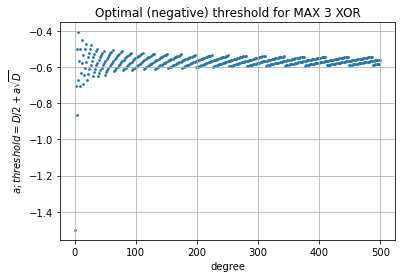

In [30]:
inps = range(1, 500)
plt.scatter(inps, [(get_argmax(D, 3, True) - D/2)/D**0.5 for D in inps], s=3)
plt.xlabel("degree")
plt.ylabel("$ a; threshold= D/2 + a \sqrt{D}$")
plt.title("Optimal (negative) threshold for MAX 3 XOR")
plt.grid()

# Comparison for MAX 3 XOR

In [31]:
def get_max(D, k):
    inps = range(-1, D+2)
    return max([general_improvement(D, t, k) for t in inps])

Text(0, 0.5, 'C; fraction = $1/2 + C/\\sqrt{D}$')

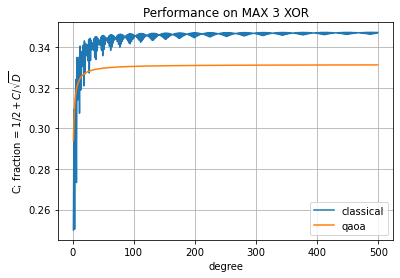

In [32]:
inps = range(1, 500)
plt.plot(inps, [get_max(D, 3)*D**0.5 for D in inps], label='classical')
plt.plot(inps, optimized_vals[:len(inps)], label='qaoa')
plt.legend()
plt.grid()
plt.title("Performance on MAX 3 XOR")
plt.xlabel("degree")
plt.ylabel("C; fraction = $1/2 + C/\sqrt{D}$")

Zooming in at small degree:

Text(0, 0.5, 'C; fraction = $1/2 + C/\\sqrt{D}$')

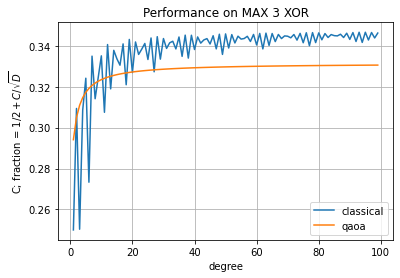

In [33]:
inps = range(1, 100)
plt.plot(inps, [get_max(D, 3)*D**0.5 for D in inps], label='classical')
plt.plot(inps, optimized_vals[:len(inps)], label='qaoa')
plt.legend()
plt.grid()
plt.title("Performance on MAX 3 XOR")
plt.xlabel("degree")
plt.ylabel("C; fraction = $1/2 + C/\sqrt{D}$")

When does QAOA win?

In [34]:
np.array(inps)[[get_max(D, 3)*D**0.5 - o < 0 for D, o in zip(inps, optimized_vals[:len(inps)])]]

array([ 1,  3,  4,  6,  8, 11, 13, 18, 20, 27])

# Threshold algorithm for MAX K XOR

The performance increases with $k$:

Text(0, 0.5, 'C; fraction = $1/2 + C/\\sqrt{D}$')

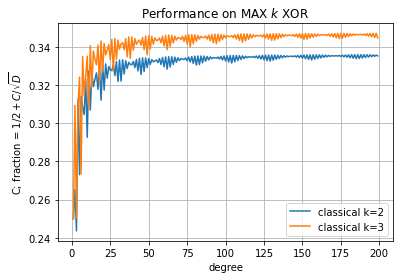

In [35]:
inps = range(1, 200)
for k in range(2, 4):
    plt.plot(inps, [get_max(D, k)*D**0.5 for D in inps],label="classical k=" + str(k))
plt.grid()
plt.legend()
plt.title("Performance on MAX $k$ XOR")
plt.xlabel("degree")
plt.ylabel("C; fraction = $1/2 + C/\sqrt{D}$")

Text(0, 0.5, 'C; fraction = $1/2 + C/\\sqrt{D}$')

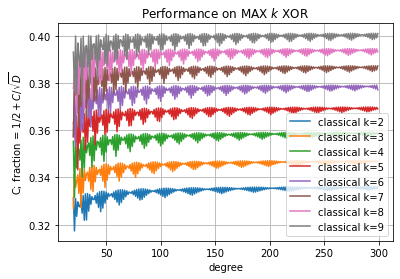

In [36]:
inps = range(20, 300)
for k in range(2, 10):
    plt.plot(inps, [get_max(D, k)*D**0.5 for D in inps],label="classical k=" + str(k))
plt.grid()
plt.legend()
plt.title("Performance on MAX $k$ XOR")
plt.xlabel("degree")
plt.ylabel("C; fraction = $1/2 + C/\sqrt{D}$")

Text(0, 0.5, 'C; fraction = $1/2 + C/\\sqrt{D}$')

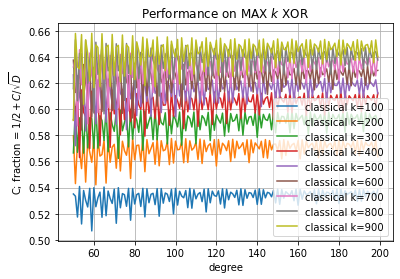

In [37]:
inps = range(50, 200)
for k in range(100, 1000, 100):
    plt.plot(inps, [get_max(D, k)*D**0.5 for D in inps],label="classical k=" + str(k))
plt.grid()
plt.legend()
plt.title("Performance on MAX $k$ XOR")
plt.xlabel("degree")
plt.ylabel("C; fraction = $1/2 + C/\sqrt{D}$")

What about the optimal threshold?

Text(0, 0.5, 'a; threshold = $D/2 + a\\sqrt{D}$')

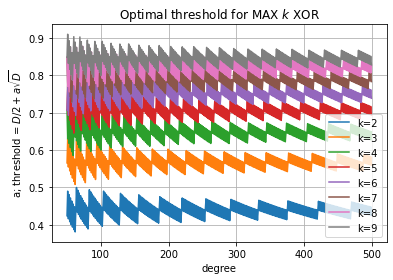

In [38]:
inps = range(50, 500)
for k in range(2,10):
    plt.plot(inps, [abs(get_argmax(D, k) - D/2)/D**0.5 for D in inps], label='k=' + str(k))
plt.grid()
plt.legend()
plt.title("Optimal threshold for MAX $k$ XOR")
plt.xlabel("degree")
plt.ylabel("a; threshold = $D/2 + a\sqrt{D}$")

### Large degree approximation

alpha (k=2): -0.4384483844838448
improvement*rtD: 0.33648925802613555
alpha (k=3): -0.5661056610566105
improvement*rtD: 0.34753464968074316
alpha (k=4): -0.6461164611646116
improvement*rtD: 0.35948123367974816
alpha (k=5): -0.7040770407704077
improvement*rtD: 0.37007481521513996
alpha (k=6): -0.7493114931149312
improvement*rtD: 0.37934716987803424


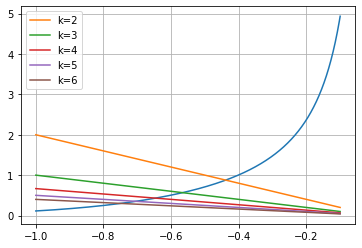

In [39]:
def f(alpha):
    return -erf(2**0.5 * alpha)

def grtD(alpha):
    return (2/np.pi)**0.5 * np.e**(-2*alpha*alpha)

def large_degree_improvement(alpha, k):
    return f(alpha)**k * (k/2) * (-2*alpha)/(k-1)

inps = np.linspace(-1, -0.1, 100000)
plt.plot(inps, [grtD(i)/f(i) for i in inps])
for k in range(2, 7):
    plt.plot(inps, -2*inps/(k-1), label='k=' + str(k))
    alpha = inps[[(grtD(i)/f(i)+2*i/(k-1) > 0) for i in inps]][0]
    print('alpha (k=' + str(k) + '):', alpha)
    print('improvement*rtD:', large_degree_improvement(alpha, k))
plt.legend()
plt.grid()

We can use scipy to find the optimal threshold and value.

In [40]:
fmaker = lambda k: lambda i: abs(grtD(i)/f(i)+2*i/(k-1))

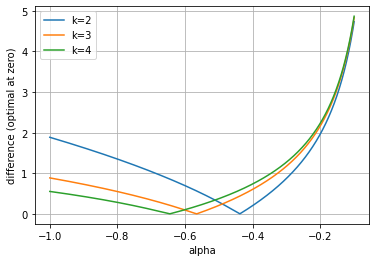

In [41]:
for k in [2,3,4]:
    plt.plot(inps, fmaker(k)(inps), label='k=' + str(k))
plt.xlabel("alpha")
plt.ylabel("difference (optimal at zero)")
plt.grid()
plt.legend()

In [42]:
ks = range(2, 100)
best_alphas = [minimize(fmaker(k), -1, method='Nelder-Mead', options={"ftol":1e-10}).x[0] for k in ks]
best_threshold_perf = [large_degree_improvement(a, k) for a,k in zip(best_alphas, ks)]

In [43]:
for i in range(18):
    print("k:", ks[i], "alpha:", best_alphas[i], "perf:", best_threshold_perf[i])

k: 2 alpha: -0.4384504927322263 perf: 0.33649336434608373
k: 3 alpha: -0.566110652685165 perf: 0.34754360662427763
k: 4 alpha: -0.646119719278067 perf: 0.35948708249696404
k: 5 alpha: -0.7040850546211003 perf: 0.37008946845499674
k: 6 alpha: -0.7493118736892935 perf: 0.37934788180340984
k: 7 alpha: -0.7862569719552992 perf: 0.3874867747324553
k: 8 alpha: -0.817399865761399 perf: 0.39471621046350674
k: 9 alpha: -0.8442601535469293 perf: 0.40120335548614106
k: 10 alpha: -0.8678350865840913 perf: 0.4070774997450675
k: 11 alpha: -0.8888135105371475 perf: 0.4124388540093239
k: 12 alpha: -0.9076905906200408 perf: 0.41736591797938943
k: 13 alpha: -0.924833858758211 perf: 0.4219210415038646
k: 14 alpha: -0.9405233614146706 perf: 0.4261543840769254
k: 15 alpha: -0.9549772322177886 perf: 0.43010682728185895
k: 16 alpha: -0.9683685787022114 perf: 0.43381207871486654
k: 17 alpha: -0.9808370001614093 perf: 0.4372982310985033
k: 18 alpha: -0.9924966532737016 perf: 0.4405889197979946
k: 19 alpha: -1.

Text(0.5, 1.0, 'Best asymptotic performance of threshold algorithm for MAX K XOR')

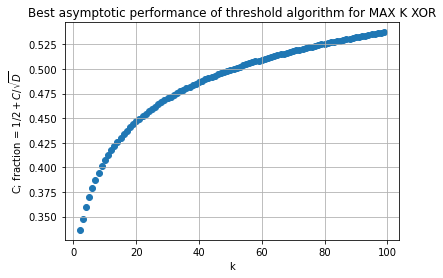

In [44]:
plt.scatter(ks, best_threshold_perf)
plt.grid()
plt.xlabel("k")
plt.ylabel("C; fraction = $1/2 + C/\sqrt{D}$")
plt.title("Best asymptotic performance of threshold algorithm for MAX K XOR")

Comparing the expression with its large-degree asymptotic form

In [45]:
@lru_cache(maxsize=int(1e7))
def long_range_improvement(D, t, k):
    alpha = (t - D/2)*D**-0.5
    val_delta = (2/np.pi/D)**0.5 * np.e**(-2*alpha*alpha)
    val_g = 0.5 + 0.5*erf(2**0.5 * alpha) + 0.5 * val_delta
    return 0.25 * ( (1-2*val_g + 2*val_delta)**k - (1 - 2*val_g)**k )

Text(0.5, 1.0, 'asymptotic (large-degree) vs generic performance of threshold algorithm; D=1000')

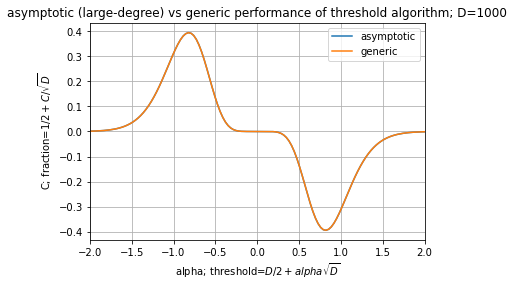

In [46]:
D = 1000
k = 8
inps = np.array(list(range(-1, D+2)))
plt.plot((inps/D - 1/2)*D**0.5, [long_range_improvement(D, t, k)*D**0.5 for t in inps], label='asymptotic')
plt.plot((inps/D - 1/2)*D**0.5, [general_improvement(D, t, k)*D**0.5 for t in inps], label='generic')
plt.xlim(-2, 2)
plt.grid()
plt.xlabel("alpha; threshold=$D/2 + alpha \sqrt{D}$")
plt.ylabel("C; fraction=$1/2 + C/\sqrt{D}$")
plt.legend()
plt.title("asymptotic (large-degree) vs generic performance of threshold algorithm; D="  +str(D))

# QAOA for MAX K XOR

We have a relationship from $\gamma$ to $\beta$. So let's plot performance as a single-variable function:

In [47]:
# @lru_cache(maxsize=int(1e7))
def gamma_from_beta(b, k, D):
    return atan( ((tan(2*b)**(-2) + 1)/k/D)**0.5 )

In [48]:
def f(b, k, D):
    p, q = cos(2*b), sin(2*b)
    g = gamma_from_beta(b, k, D)
    c, s = cos(g), sin(g)
    return -0.25*s*1j*( (p + 1j*q*c**D)**k - (p - 1j*q*c**D)**k )

k: 3 D: 2 beta/pi: 0.09113411341134134 gamma: 0.6457133550969802 perf: 0.29410412861806556
k: 3 D: 5 beta/pi: 0.09178417841784199 gamma: 0.4422524799948612 perf: 0.3146569554910147
k: 3 D: 10 beta/pi: 0.09203420342034223 gamma: 0.3223806563933743 perf: 0.32268419004512405
k: 3 D: 20 beta/pi: 0.09215921592159236 gamma: 0.23167755729751552 perf: 0.32697175492210245
k: 3 D: 100 beta/pi: 0.09228422842284248 gamma: 0.10498972786802262 perf: 0.33054742740112547
k: 3 D: 500 beta/pi: 0.09230923092309251 gamma: 0.04707999959190555 perf: 0.33127896219847697
k: 3 D: 1000 beta/pi: 0.09230923092309251 gamma: 0.033302887938561315 perf: 0.33137080088961723
k: 3 D: 10000 beta/pi: 0.09230923092309251 gamma: 0.010534803199471842 perf: 0.3314535299965894
k: 4 D: 2 beta/pi: 0.07350735073507372 gamma: 0.6707077469306936 perf: 0.31273335595182417
k: 4 D: 5 beta/pi: 0.0744824482448247 gamma: 0.460203752247109 perf: 0.33641563218166026
k: 4 D: 10 beta/pi: 0.07485748574857508 gamma: 0.33568475060518954 perf: 0

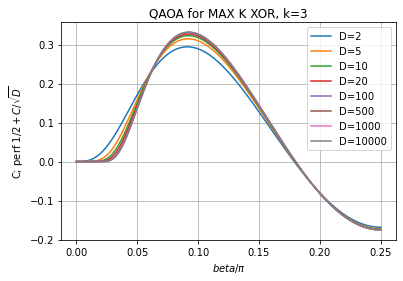

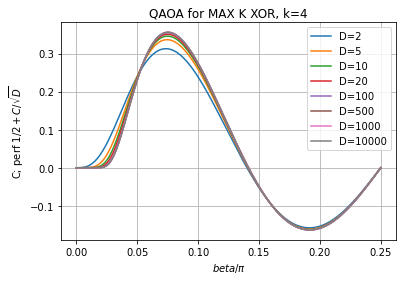

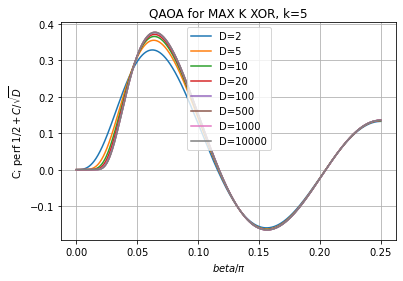

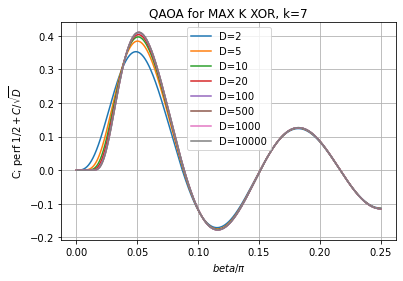

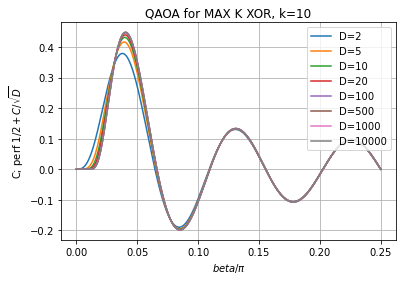

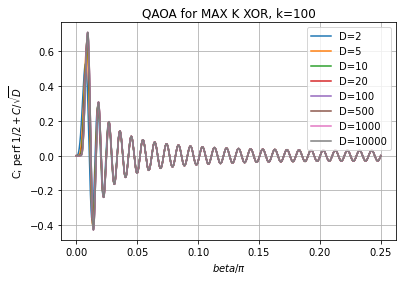

In [49]:
for k in [3, 4, 5, 7, 10, 100]:
    plt.figure()
    Ds = [2, 5, 10, 20, 100, 500, 1000, 10000]
    for D in Ds:
        inps = np.linspace(1e-15, np.pi/4, 10000)
        outs = [complex(f(i, k, D)).real*D**0.5 for i in inps]
        plt.plot(inps/np.pi, outs, label="D=" + str(D))
        print('k:', k, "D:", D, 'beta/pi:', inps[np.argmax(outs)]/np.pi, 'gamma:', gamma_from_beta(inps[np.argmax(outs)], k, D), 'perf:', np.max(outs))
    plt.title("QAOA for MAX K XOR, k=" + str(k))
    plt.grid()
    plt.ylabel("C; perf $1/2 + C/ \sqrt{D}$")
    plt.xlabel("$ beta / \pi$")
    plt.legend()

Find the maximum performance of QAOA for any k and D:

In [50]:
fmaker = lambda k, D: lambda i: -complex(f(i, k, D)).real*D**0.5

In [51]:
def get_qaoa_max(k,D):
    # do pass to find approximate optimum
    inps = np.linspace(1e-15, np.pi/4, 100)
    outs = [complex(f(i, k, D)).real*D**0.5 for i in inps]
    return -minimize(fmaker(k, D), inps[np.argmax(outs)]).fun

CPU times: user 7.87 s, sys: 16 ms, total: 7.89 s
Wall time: 7.88 s


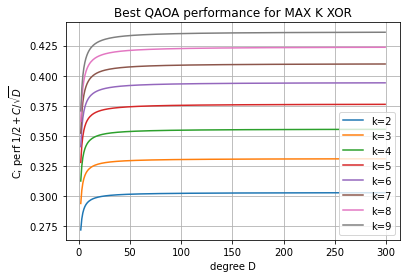

In [52]:
%%time
for k in range(2, 10):
    Ds = range(2, 300)
    qaoa_kxor = [get_qaoa_max(k,D) for D in Ds]
    plt.plot(Ds, qaoa_kxor, label="k=" + str(k))
plt.grid()
plt.xlabel('degree D')
plt.legend()
plt.ylabel("C; perf $1/2 + C/ \sqrt{D}$")
plt.title("Best QAOA performance for MAX K XOR")
plt.savefig('qaoa_best_maxkxor.png',  dpi=300)

### Limiting behavior for QAOA on MAX K XOR

In [53]:
def qaoa_asymptotic_kxor(k,t):
    if t*t*k < 1:
        return 0
    term_1 = (t*t*k - 1)**0.5 + 1j*np.e**(-t*t/2)
    term_2 = (t*t*k - 1)**0.5 - 1j*np.e**(-t*t/2)
    return -0.25*1j * t**(1-k) * k**(-k/2) * (term_1**k - term_2**k)

k= 2 Max: 0.30326532976533727 at t= 1.000010000100001
k= 3 Max: 0.33146272666069077 at t= 1.053510535105351
k= 4 Max: 0.3559421057897224 at t= 1.097790977909779
k= 5 Max: 0.3767105761875506 at t= 1.134771347713477
k= 6 Max: 0.3945945274726129 at t= 1.1663716637166373
k= 7 Max: 0.41025178270098717 at t= 1.1939319393193932
k= 8 Max: 0.42415677803753304 at t= 1.2183321833218332
k= 9 Max: 0.436652898412887 at t= 1.2402124021240213
k= 10 Max: 0.4479939244835788 at t= 1.2600526005260053
k= 11 Max: 0.45837176828801823 at t= 1.2781727817278172
k= 12 Max: 0.46793469585178904 at t= 1.2948529485294853
k= 13 Max: 0.4767994633283053 at t= 1.3103131031310313
k= 14 Max: 0.48505957497866997 at t= 1.3246932469324693
k= 15 Max: 0.4927910317504684 at t= 1.3381533815338154
k= 16 Max: 0.500056421040816 at t= 1.3508135081350814
k= 17 Max: 0.5069078845008667 at t= 1.3627336273362733
k= 18 Max: 0.5133893126807297 at t= 1.3739937399373994
k= 19 Max: 0.5195379937755544 at t= 1.3846938469384693
k= 20 Max: 0.5253

Text(0, 0.5, 'C; perf $1/2 + C/ \\sqrt{D}$')

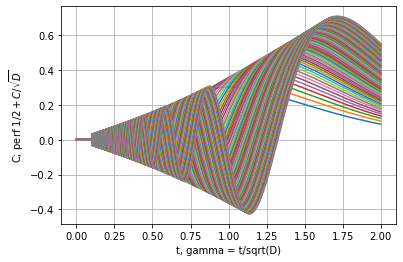

In [54]:
qaoa_asymptotic_maxes = []
for k in range(2, 100):
    inps = np.linspace(0, 2, 100000)
    outs = [qaoa_asymptotic_kxor(k,i).real for i in inps]
    plt.plot(inps, outs, label="k=" + str(k))
    if k < 20 or k % 5 == 0:
        print("k=", str(k), "Max:", np.nanmax(outs), "at t=", inps[np.nanargmax(outs)])
    qaoa_asymptotic_maxes.append(np.nanmax(outs))
plt.grid()
plt.xlabel("t, gamma = t/sqrt(D)")
plt.ylabel("C; perf $1/2 + C/ \sqrt{D}$")
# plt.legend()

# Comparison for MAX K XOR

CPU times: user 7.87 s, sys: 156 ms, total: 8.03 s
Wall time: 7.72 s


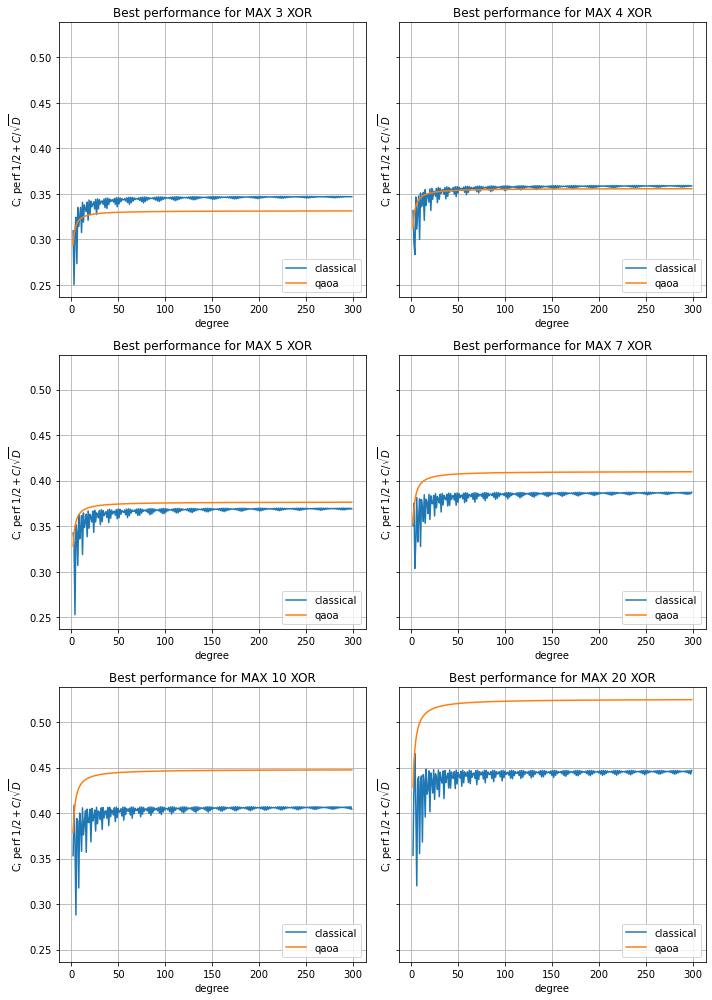

In [55]:
%%time
fig, axs = plt.subplots(3, 2, sharey=True, figsize=(10, 14))
axs = axs.reshape(-1,)
ks = [3, 4, 5, 7, 10, 20]
for i in range(len(ks)):
    ax = axs[i]
    k = ks[i]
    Ds = range(2,300)
    ax.plot(Ds, [get_max(D, k)*D**0.5 for D in Ds], label='classical')
    ax.plot(Ds, [get_qaoa_max(k,D) for D in Ds], label='qaoa')
    ax.grid()
    ax.set_xlabel('degree')
    ax.legend(loc='lower right')
    ax.set_ylabel("C; perf $1/2 + C/ \sqrt{D}$")
    ax.set_title("Best performance for MAX " + str(k) + " XOR")
fig.tight_layout()
plt.savefig('comparison.png',  dpi=300)

So for $k > 4$, the QAOA does better than the threshold algorithm.

This is true even in the large-degree limit.

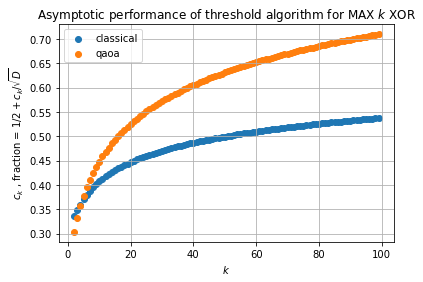

In [56]:
ks = range(2, 100)
plt.scatter(ks[:len(best_threshold_perf)], best_threshold_perf, label='classical')
plt.scatter(ks[:len(qaoa_asymptotic_maxes)], qaoa_asymptotic_maxes, label='qaoa')
plt.grid()
plt.xlabel("$k$")
plt.ylabel("$c_k$ , fraction = $1/2 +  c_k /\sqrt{D}$")
plt.legend()
plt.title("Asymptotic performance of threshold algorithm for MAX $k$ XOR")
plt.savefig('asymptotic_comparison.png',  dpi=300)

In [57]:
def logfit(x, y, deg=1):
    logx = np.log(x)
    logy = np.log(y)
    return np.polyfit(logx,logy,deg=deg)

# poly = np.poly1d(coeffs)
# yfit = lambda x: np.exp(poly(np.log(x)))
# plt.loglog(inps, yfit(inps))
# plt.loglog(inps, dataset)

In [58]:
dataset = qaoa_asymptotic_maxes
inps = ks[:len(dataset)]

qaoa_coeffs = logfit(inps, dataset, deg=1)
print(qaoa_coeffs)

dataset = best_threshold_perf
inps = ks[:len(dataset)]

threshold_coeffs = logfit(inps, dataset, deg=1)
print(threshold_coeffs)

[ 0.21003313 -1.28885354]
[ 0.12296241 -1.17898104]


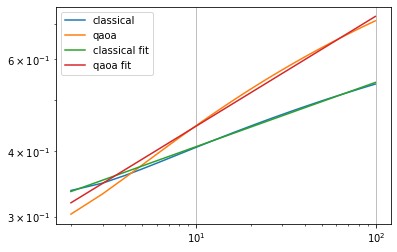

In [59]:
plt.loglog(ks, best_threshold_perf, label='classical')
plt.loglog(ks[:len(qaoa_asymptotic_maxes)], qaoa_asymptotic_maxes, label='qaoa')
plt.loglog(ks, [(np.e**threshold_coeffs[1])*k**threshold_coeffs[0] for k in ks], label='classical fit')
plt.loglog(ks, [(np.e**qaoa_coeffs[1])*k**qaoa_coeffs[0] for k in ks], label='qaoa fit')
plt.legend()
plt.grid()

This suggests that QAOA's performance scales as $k^{0.21}$ and the threshold algorithm's performance scales as $k^{0.12}$.

In [60]:
print("Ending time:", time.ctime())

Ending time: Mon Jun 14 23:38:02 2021
